In [19]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings("ignore")


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import numpy as np
import collections
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

We got a baseline accuracy of 72.3% with full fine tuning the GC dataset with the pre-trained model EfficientNetB3. Here the objective is to see if we can improve the accuracy if we use a model trained on a much larger CRC histopathology dataset for the same 8 class classification. 

In [20]:


path = "/kaggle/input/gastric-cancer-histopathology-tissue-image-dataset/HMU-GC-HE-30K/all_image"
tissue_types = os.listdir(path)
tissue_types.sort()
tissue_types



['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

ADI


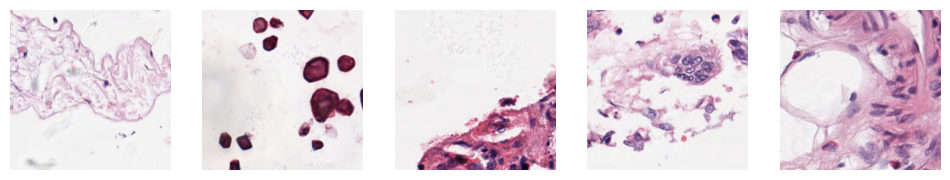

DEB


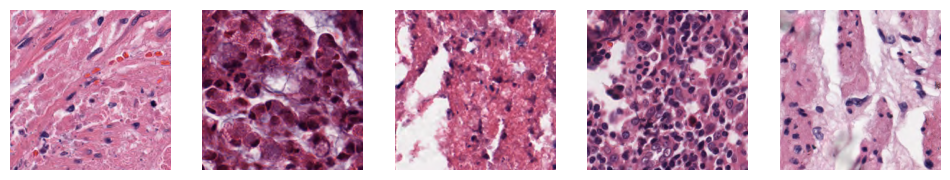

LYM


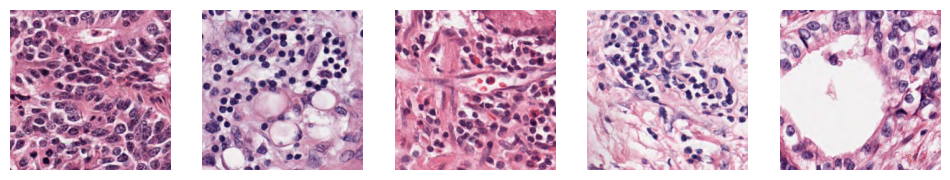

MUC


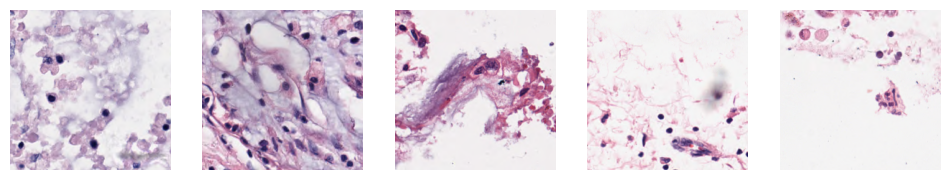

MUS


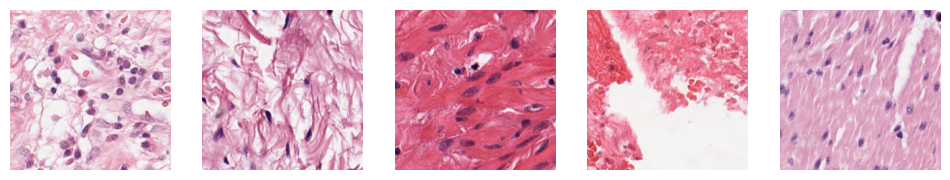

NOR


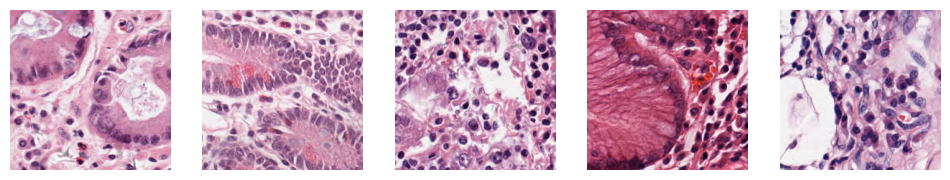

STR


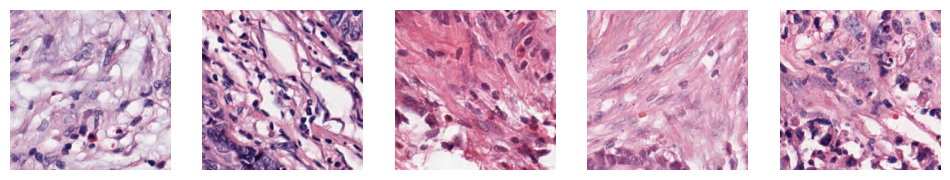

TUM


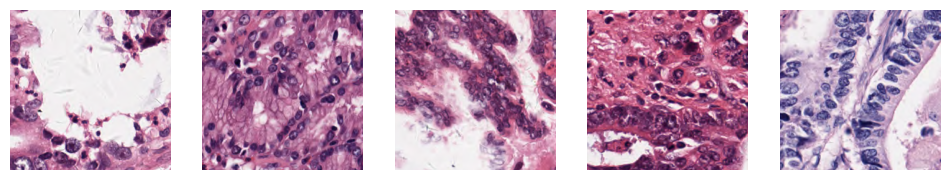

In [21]:


images_per_label = 5
for tissue in tissue_types:
    folder_path = os.path.join(path, tissue)
    folder_files = os.listdir(folder_path)
    random_ind=np.random.randint(0, len(folder_files),images_per_label)
    fig, ax = plt.subplots(1, images_per_label, figsize=(12, 10))
    print(tissue)
    for i, ind in enumerate(random_ind):     
        img = plt.imread(folder_path+'/'+folder_files[ind])
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()



In [22]:
for tissue in tissue_types:
    folder_path = os.path.join(path, tissue)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path)])
        print(f"{tissue}: {num_images} images")

ADI: 3887 images
DEB: 3887 images
LYM: 3887 images
MUC: 3887 images
MUS: 3887 images
NOR: 3887 images
STR: 3887 images
TUM: 3887 images


In [23]:
# 85-15 split 

train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  labels='inferred',
  validation_split=0.15,
  subset='both',
  seed=111,
  batch_size=32,
  image_size=(224, 224),
  shuffle=True
  )

Found 31096 files belonging to 8 classes.
Using 26432 files for training.
Using 4664 files for validation.


In [24]:
train_ds.class_names

['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

In [25]:
image, label = next(iter(train_ds))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


In [26]:
train_labels = []
for _, labels in train_ds:
    train_labels.extend(labels.numpy())

train_label_counts = collections.Counter(train_labels)
print("Train label distribution:")
print(dict(sorted(train_label_counts.items())))

val_labels = []
for _, labels in val_ds:
    val_labels.extend(labels.numpy())

val_label_counts = collections.Counter(val_labels)
print("\nValidation label distribution:")
print(dict(sorted(val_label_counts.items())))


Train label distribution:
{0: 3325, 1: 3324, 2: 3280, 3: 3308, 4: 3286, 5: 3303, 6: 3319, 7: 3287}

Validation label distribution:
{0: 562, 1: 563, 2: 607, 3: 579, 4: 601, 5: 584, 6: 568, 7: 600}


In [14]:
def preprocess_train(image, label):
    #image = data_augmentation(image, training=True)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

def preprocess_val(image, label):
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

train_ds_clean = train_ds.map(preprocess_train).prefetch(tf.data.AUTOTUNE)
val_ds_clean = val_ds.map(preprocess_val).prefetch(tf.data.AUTOTUNE)


In [15]:
# save the number of class labels
num_labels=len(train_ds.class_names)

# Pre-trained model on CRC histopathology dataset

In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Rebuild the model architecture
input_tensor = tf.keras.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.EfficientNetB3(
    weights=None,
    include_top=False,
    input_tensor=input_tensor
)
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(8, activation="softmax")(x)
model = tf.keras.Model(inputs=input_tensor, outputs=output)

# Load the CRC-trained weights
model.load_weights("/kaggle/input/efficientnetb3_crc_100k_best_model/tensorflow2/default/1/efficientnetb3_crc_baseline.h5")

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=4, # how many epochs to wait before stopping
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="/kaggle/working/customtrained_from_crc_baseline.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.3,             
    patience=3,            
    verbose=1,              
    min_lr=1e-6           
)


In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_ds_clean, epochs=40, validation_data=val_ds_clean, callbacks=[early_stopping,checkpoint_callback])

Epoch 1/40


I0000 00:00:1752388944.557851    1311 service.cc:148] XLA service 0x7e01500184f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752388944.557914    1311 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752388944.557920    1311 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1752388952.789503    1311 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1752388969.972598    1311 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752388970.120074    1311 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1752388970.685704    1311 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

826/826 ━━━━━━━━━━━━━━━━━━━━ 426s 338ms/step - accuracy: 0.6030 - loss: 1.1569 - val_accuracy: 0.7069 - val_loss: 0.7769
Epoch 2/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 261s 316ms/step - accuracy: 0.7529 - loss: 0.6569 - val_accuracy: 0.7264 - val_loss: 0.7379
Epoch 3/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 259s 313ms/step - accuracy: 0.8341 - loss: 0.4535 - val_accuracy: 0.7142 - val_loss: 0.8458
Epoch 4/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 260s 315ms/step - accuracy: 0.9022 - loss: 0.2830 - val_accuracy: 0.7112 - val_loss: 0.9476
Epoch 5/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 260s 314ms/step - accuracy: 0.9267 - loss: 0.2032 - val_accuracy: 0.7129 - val_loss: 1.0450
Epoch 6/40
826/826 ━━━━━━━━━━━━━━━━━━━━ 259s 314ms/step - accuracy: 0.9512 - loss: 0.1384 - val_accuracy: 0.7148 - val_loss: 1.1103


As we can see the minimum validation loss is 0.7379 for a validation accuracy of 72.6%. This is not a lot of improvement compared to the pre-trained EfficientNetB3 model as it is. There is a ~2% improvement in the validation loss though. Also the model is overfitting fast. So we can try to do data augmentation and see if that is gonna help.

# Augmentation + Pre-trained model on CRC histopathology dataset

In [27]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal_and_vertical"), 
                                         tf.keras.layers.RandomRotation(0.2),
                                         tf.keras.layers.RandomZoom(0.2),
                                         tf.keras.layers.RandomBrightness(0.2),
                                         tf.keras.layers.RandomContrast(0.2)])

In [28]:
def preprocess_train(image, label):
    #image = data_augmentation(image, training=True)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

def preprocess_val(image, label):
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

train_ds_clean = train_ds.map(preprocess_train).prefetch(tf.data.AUTOTUNE)
val_ds_clean = val_ds.map(preprocess_val).prefetch(tf.data.AUTOTUNE)


In [29]:
base_model = tf.keras.models.load_model("/kaggle/input/efficientnetb3_crc_100k_best_model/tensorflow2/default/1/efficientnetb3_crc_baseline.h5")

In [30]:
from tensorflow.keras import Model
base_model = Model(inputs=base_model.input, outputs=base_model.layers[-3].output)
x=tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output=tf.keras.layers.Dense(8, activation="softmax")(x)
model=tf.keras.Model(inputs=base_model.input,outputs=output)

In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=4, # how many epochs to wait before stopping
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "/kaggle/working/custom_crc_trained_with_aug_nonorm.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     
    factor=0.3,             
    patience=3,            
    verbose=1,              
    min_lr=1e-6           
)


In [32]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_ds_clean, epochs=16, validation_data=val_ds_clean, callbacks=[early_stopping])

Epoch 1/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 358s 325ms/step - accuracy: 0.2972 - loss: 1.8611 - val_accuracy: 0.5549 - val_loss: 1.3366
Epoch 2/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 256s 310ms/step - accuracy: 0.5562 - loss: 1.2734 - val_accuracy: 0.6106 - val_loss: 1.1119
Epoch 3/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 256s 310ms/step - accuracy: 0.6003 - loss: 1.1000 - val_accuracy: 0.6331 - val_loss: 1.0200
Epoch 4/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 255s 308ms/step - accuracy: 0.6194 - loss: 1.0217 - val_accuracy: 0.6484 - val_loss: 0.9688
Epoch 5/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 255s 309ms/step - accuracy: 0.6375 - loss: 0.9838 - val_accuracy: 0.6597 - val_loss: 0.9347
Epoch 6/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 256s 310ms/step - accuracy: 0.6506 - loss: 0.9413 - val_accuracy: 0.6672 - val_loss: 0.9094
Epoch 7/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 255s 309ms/step - accuracy: 0.6597 - loss: 0.9143 - val_accuracy: 0.6756 - val_loss: 0.8898
Epoch 8/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 255s 309ms/step - accuracy: 0.6674 -

In [33]:

history1 = model.fit(train_ds_clean, epochs=16, validation_data=val_ds_clean, callbacks=[early_stopping])

Epoch 1/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 255s 309ms/step - accuracy: 0.7166 - loss: 0.7537 - val_accuracy: 0.7084 - val_loss: 0.7928
Epoch 2/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 254s 307ms/step - accuracy: 0.7257 - loss: 0.7424 - val_accuracy: 0.7110 - val_loss: 0.7873
Epoch 3/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 254s 308ms/step - accuracy: 0.7262 - loss: 0.7329 - val_accuracy: 0.7112 - val_loss: 0.7818
Epoch 4/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 254s 308ms/step - accuracy: 0.7230 - loss: 0.7254 - val_accuracy: 0.7116 - val_loss: 0.7780
Epoch 5/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 254s 307ms/step - accuracy: 0.7377 - loss: 0.7021 - val_accuracy: 0.7125 - val_loss: 0.7743
Epoch 6/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 254s 308ms/step - accuracy: 0.7359 - loss: 0.7013 - val_accuracy: 0.7133 - val_loss: 0.7698
Epoch 7/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 254s 308ms/step - accuracy: 0.7409 - loss: 0.6853 - val_accuracy: 0.7138 - val_loss: 0.7660
Epoch 8/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 254s 307ms/step - accuracy: 0.7456 -

In [34]:

history3 = model.fit(train_ds_clean, epochs=16, validation_data=val_ds_clean, callbacks=[early_stopping])

Epoch 1/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 255s 309ms/step - accuracy: 0.7715 - loss: 0.6079 - val_accuracy: 0.7198 - val_loss: 0.7462
Epoch 2/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 255s 308ms/step - accuracy: 0.7756 - loss: 0.5981 - val_accuracy: 0.7208 - val_loss: 0.7452
Epoch 3/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 253s 307ms/step - accuracy: 0.7746 - loss: 0.6007 - val_accuracy: 0.7208 - val_loss: 0.7432
Epoch 4/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 255s 308ms/step - accuracy: 0.7843 - loss: 0.5845 - val_accuracy: 0.7204 - val_loss: 0.7430
Epoch 5/16
826/826 ━━━━━━━━━━━━━━━━━━━━ 255s 309ms/step - accuracy: 0.7847 - loss: 0.5742 - val_accuracy: 0.7234 - val_loss: 0.7417


Validation loss and accuracy started plateauing. Validation accuracy is around same as before. Validation loss is higher than the one without augmentation.